# Diffusion Monte Carlo Method

We want to study the $H_2$ molecule using DMC. In particular we are interested in the ground state energy for different bond lenths.
The Diffusion Monte Carlo method (DMC) for the computation of ground states and ground state energies is based on two ideas:
1. Compute the time evolution in complex time direction, which transforms the Schrödinger equation into a diffusion equation.
2. Use Monte Carlo sampling to compute solutions to the resulting equation using a path integral approach.

For an overview on DMC see (I. Kosztin, B. Faber, K. Schulten, Introduction to the diffusion Monte Carlo method, Am. J. Phys. 64 (1996)).

In [1]:
# Pkg.add(Plots)
using Plots
using LaTeXStrings

# potential for H2
function V(x, R)
    x1, x2, x3, x4, x5, x6 = x[1], x[2], x[3], x[4], x[5], x[6]
    -1. / sqrt((x1 - R/2.)^2 + x2^2 + x3^2) +
    -1. / sqrt((x1 + R/2.)^2 + x2^2 + x3^2) +
    -1. / sqrt((x4 - R/2.)^2 + x5^2 + x6^2) +
    -1. / sqrt((x4 + R/2.)^2 + x5^2 + x6^2) +
     1. / sqrt((x1 - x4)^2 + (x2 - x5)^2 + (x3 - x6)^2) +
     1. / R
    # slower but clearer version:
#     R1 = [ R / 2., 0., 0.]
#     R2 = [-R / 2., 0., 0.]
#     - 1 / norm(x[1:3] - R1) - 1 / norm(x[1:3] - R2) - 1 / norm(x[4:6] - R1) - 1 / norm(x[4:6] - R2) +
#      1 / norm(x[1:3] - x[4:6]) + 1 / R
end
# potential for hydrogen atom
# function V(x, R)
#     x1, x2, x3 = x[1], x[2], x[3]
#     -1. / sqrt((x1 - R/2.)^2 + x2^2 + x3^2)
# #     - 1 / norm(x)
# end
function V(X::Matrix, R)
    v = zeros(size(X, 2))
    for i = 1:length(v)
        v[i] = V(X[:, i], R)
    end
    return v
end

function W(v, Δt, Eᵣ)
    exp(- (v - Eᵣ) * Δt)
end
function W(v::Vector, Δt, Eᵣ)
    prodW = zeros(v)
    for i = 1:length(v)
        prodW[i] = W(v[i], Δt, Eᵣ)
    end
    return prodW
end

W (generic function with 2 methods)

In [2]:
function DMC(Nₓ=1000, Nₜ=1000, Δt=0.1, R=1.389)
    d = 6 # for hydrogen atom: 3
    sqrt_Δt = sqrt(Δt)

    # set up initial distribution
    X = 0.1 * randn(d, Nₓ)
    X[1, :] += 1.
    X[4, :] += -1. # comment out for hydrogen atom

    # compute initial guess of the ground state energy
    V_X = V(X, R)
    Eᵣ = mean(V_X)
    Eᵣ_history = [Eᵣ]

    for i = 1:Nₜ
        # diffution step
        X += sqrt_Δt * randn(size(X))
        # compute weights
        w = W(V_X, Δt, Eᵣ)
        w = min(w, 3.)
        # birth death process
        w_sum = sum(w)
        K = floor(Int, Nₓ / w_sum * w  + rand(length(w)))
        # paper uses the following instead
#         K = floor(Int, w  + rand(length(w)))
        mask0 = K .== 0
        mask1 = K .== 1
        mask2 = K .== 2
        mask3 = K .== 3
        mask = !mask0
        if sum(mask) == 0
            break
        end
        X_new = X[:, mask]
        X_new = hcat(X_new, X[:, mask2])
        X_new = hcat(X_new, X[:, mask3])
        X_new = hcat(X_new, X[:, mask3])
        X = X_new

        # compute new ground state energy
        V_X = V(X, R)
        Eᵣ = mean(V_X)
        # paper uses the following instead
#         Eᵣ = mean(V_X) + 1. / Δt * (1 - size(X, 2) / length(mask))
        push!(Eᵣ_history, Eᵣ)
    end
    return X, Eᵣ_history
end

DMC (generic function with 5 methods)

We now compute the ground state energy for $H_2$. The equilibrium bond length is $R=1.398$.

In [3]:
R = 1.389

Nₓ = 10000 # number of replicas
Nₜ = 4000 # number of time steps
Δt = 0.05 # step size
@time (X, Eᵣ_history) = DMC(Nₓ, Nₜ, Δt, R)
println("Ground state energy: ", mean(Eᵣ_history[div(end, 2):end]), " standard deviation: ", std(Eᵣ_history[div(end, 2):end]))

 13.198980 seconds (156.84 M allocations: 20.924 GB, 6.95% gc time)
Ground state energy: -1.1514874128034207 standard deviation: 0.019648950122700452


Looking at the convergence history of $E_r$ we see that $E_r$ reaches a plateau after a short time but continues to oscillate significatly due to the stochastic nature of the Monte Carlo method.

[Plots.jl] Initializing backend: pyplot



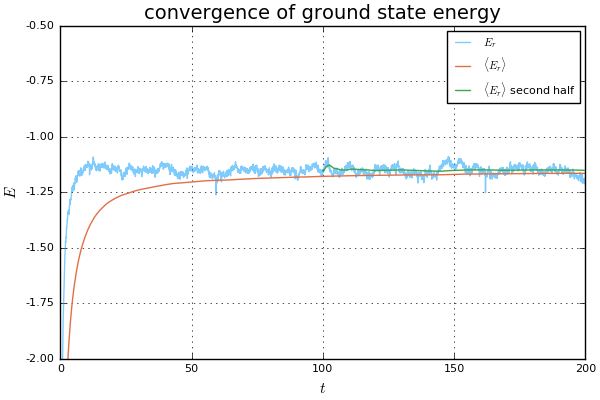

In [4]:
Nₜ = length(Eᵣ_history) - 1
t = 0:Δt:Nₜ*Δt
t2 = t[div(end, 2):end]
Eᵣ_history2 = Eᵣ_history[div(end, 2):end]
plot(t, Eᵣ_history, alpha=0.5, label=L"E_r", title="convergence of ground state energy", xlabel=L"t", ylabel=L"E", ylim=[-2, -0.5])
plot!(t, cumsum(Eᵣ_history) ./ (1:length(t)), label=L"\langle E_r \rangle")
plot!(t2, cumsum(Eᵣ_history2) ./ (1:length(t2)), label=L"$\langle E_r \rangle$ second half")


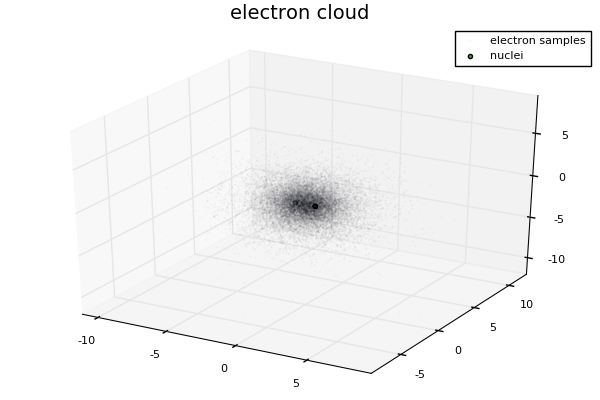

In [5]:
scatter(X'[:, 1], X'[:, 2], X'[:, 3], markeralpha=0.1, markersize=0.2, color=:blue, label="electron samples", title="electron cloud")
scatter!(X'[:, 4], X'[:, 5], X'[:, 6], markeralpha=0.1, markersize=0.2, color=:blue, label="")
scatter!([R / 2, -R / 2], [0., 0.], [0., 0.], markersize=3., markeralpha=1., label="nuclei")

We now compute the ground state energy for various internuclear distances $R \in [0.5, 8]$.

In [6]:
Nₓ = 4000
Nₜ = 4000
Δt = 0.05
t = 0:Δt:Nₜ*Δt
Rs = linspace(0.5, 8., 50)
E₀ = []

@time for R in Rs
    print("Computing ground state energy for R = $R")
    (X, Eᵣ_history) = DMC(Nₓ, Nₜ, Δt, R)
    t2 = t[div(end, 2):end]
    Eᵣ_history2 = Eᵣ_history[div(end, 2):end]
    println("  Approximate ground state energy: ", mean(Eᵣ_history2))
    push!(E₀, Eᵣ_history2)
end

Computing ground state energy for R = 0.5  Approximate ground state energy: -0.45490666296951665
Computing ground state energy for R = 0.6530612244897959  Approximate ground state energy: -0.8051887591056195
Computing ground state energy for R = 0.8061224489795918  Approximate ground state energy: -0.9774200792589114
Computing ground state energy for R = 0.9591836734693877  Approximate ground state energy: -1.0858663540530002
Computing ground state energy for R = 1.1122448979591837  Approximate ground state energy: -1.1242022141092882
Computing ground state energy for R = 1.2653061224489797  Approximate ground state energy: -1.1390127872989582
Computing ground state energy for R = 1.4183673469387754  Approximate ground state energy: -1.1613839507777632
Computing ground state energy for R = 1.5714285714285714  Approximate ground state energy: -1.1599740678544603
Computing ground state energy for R = 1.7244897959183674  Approximate ground state energy: -1.1461960817922052
Computing groun

In [14]:
plot(Rs, map(mean, E₀), yerror=2*map(std, E₀), linewidth=2, xaxis=(1:8), label=L"$E_r$ for $H_2$", xlabel=L"R", ylabel=L"E", title="Ground state energies for different bond lenths")
plot!(Rs, [2 * -0.49846250793070945 * ones(Rs) 2 * (-0.49846250793070945 + 2 * 0.0074249356095397) * ones(Rs) 2 * (-0.49846250793070945 - 2 * 0.0074249356095397) * ones(Rs)], color=:red, linestyle=[:solid :dash :dash], linealpha=[1. 0.5 0.5], label=[L"$2 E_0$ for $H$" L"error for $H$" ""])
savefig("dmc_h2.pdf")


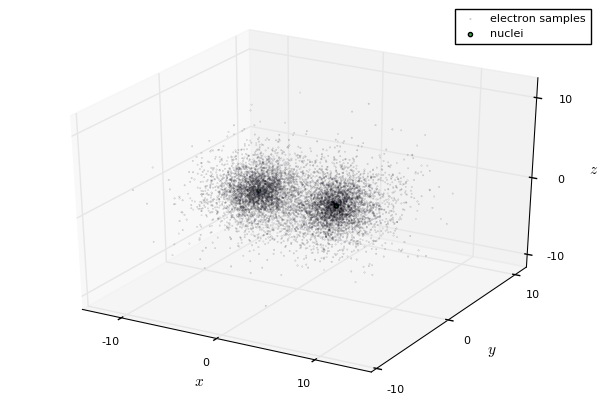

In [8]:
R = 8.
scatter(X'[:, 1], X'[:, 2], X'[:, 3], markeralpha=0.5, markersize=0.2, color=:blue, label="electron samples", xlabel=L"x", ylabel=L"y", zlabel=L"z")
scatter!(X'[:, 4], X'[:, 5], X'[:, 6], markeralpha=0.5, markersize=0.2, color=:blue, label="")
scatter!([R/2, -R/2], [0., 0.], [0., 0.], markersize=3., markeralpha=1., label="nuclei")